<h2 align="center" style="color:Black"> Companion  Геоаналитика </h2>


<b>Решение:</b>
1. Получаем матрицу признаков на активности клиентов в локациях
2. Используем кросс валидацию <b>MultilabelStratifiedKFold</b>
3. Для загрузки решения обучаем и сохраняем 7 моделей <b>XGBClassifier</b>
4. Валидация <b>9.48</b>, Паблик <b>9.27</b>

In [48]:
from pathlib import Path
import pandas as pd

!pip install h3
!pip install catboost
!pip install iterative-stratification
!pip install --upgrade xgboost

import h3
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import json
import joblib
from typing import List
from xgboost import XGBClassifier
from statistics import mean
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import warnings
from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold, MultilabelStratifiedKFold
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

%matplotlib inline

warnings.filterwarnings('ignore')

In [49]:
# метрика контеста
def mean_binary_cross_entropy(prediction, target):
    eps = 1e-8
    mbce = (-np.log(np.clip(prediction, eps, 1 - eps)) * target \
           - np.log(np.clip(1 - prediction, eps, 1 - eps)) * (1 - target)).sum(axis=1).mean()
    return mbce

#**EDA (exploratory data analysis)**

In [50]:
from pathlib import Path

root_to_data = Path('/kaggle/input/datafusion/datasets_for_df') # здесь должен быть ваш путь до папки с данными

**transactions.parquet** — файл с транзакциями:

* *h3_09* string локация
* *customer_id* int код клиента
* *datetime_id* int время суток 1 - утро, 2 - день, 3- вечер, 4 - ночь
* *count* int - количество совершенных операций, например 1
* *sum* float - сумма совершенных операций, например 3346.65
* *avg* float - среднее значение по всем совершенным операциям, например 3346.65
* *min* float - минимальное значение по всем соврешенным операциям, например 3346.65
* *max* float - максимальное значение по всем совершенным операциям, например 3346.65
* *std* float - среднее отклонение по всем совершенным операциям, может быть пустым, если операция была одна
* *count_distinct* int - количество совершенных типов операций, например 1
* *mcc_code* int - тип операции, код от 0 до 23. Не является MCC кодом в банковском понимании, просто код. например 13

In [51]:
transactions = pd.read_parquet(f'{root_to_data}/transactions.parquet')
print(transactions.shape, '\n', transactions.head(3), '\n', transactions.dtypes)

(4151096, 11) 
              h3_09  customer_id  datetime_id  count       sum       avg  \
0  8911aa4c62fffff            1            3      1   3346.65  3346.650   
1  8911aa7b5b3ffff            4            3      1    450.00   450.000   
2  8911aa63623ffff            5            3     10  11035.69  1103.569   

       min      max          std  count_distinct  mcc_code  
0  3346.65  3346.65          NaN               1        13  
1   450.00   450.00          NaN               1         8  
2    59.00  3620.18  1190.530333               6        13   
 h3_09              object
customer_id         int64
datetime_id         int64
count               int64
sum               float64
avg               float64
min               float64
max               float64
std               float64
count_distinct      int64
mcc_code            int64
dtype: object


**target.parquet**  — информация о целевой переменной

* *h3_09* — локация использования банкомата (string)
* *customer_id* — код клиента (int)

In [52]:
target_df = pd.read_parquet(f'{root_to_data}/target.parquet')
print(target_df.shape, '\n', target_df.head(3), '\n', target_df.dtypes)

(157806, 2) 
              h3_09  customer_id
0  8911aa6ac3bffff        23172
1  8911aa7a857ffff        95640
2  8911aa70b97ffff        60350 
 h3_09          object
customer_id     int64
dtype: object


<Axes: >

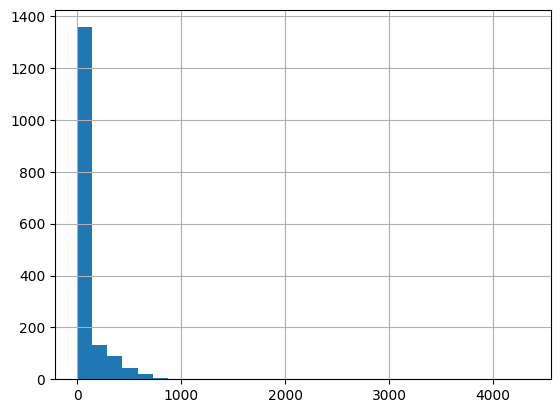

In [53]:
target_df.groupby(by='h3_09').size().hist(bins=30)

<Axes: >

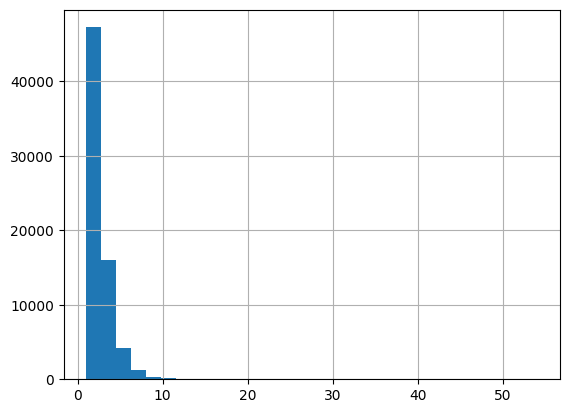

In [54]:
target_df.groupby(by='customer_id').size().hist(bins=30)

**hexses_data.lst** - список всех геолокаций, где возможно снятие наличности.

In [55]:
with open(f'{root_to_data}/hexses_data.lst', 'r') as file:
  hexses_data = [x.strip() for x in file.readlines()]
print(len(hexses_data), '\n', hexses_data[0:5])

8154 
 ['89118180927ffff', '89118180d27ffff', '891181820abffff', '891181840a7ffff', '891181844c3ffff']


**hexses_target.lst** - список всех геолокаций, где пользователь мог совершить какую-либо транзакцию.


In [56]:
with open(f'{root_to_data}/hexses_target.lst', 'r') as file:
  hexses_target = [x.strip() for x in file.readlines()]
print(len(hexses_target), '\n', hexses_target[0:5])

1657 
 ['8911818610bffff', '89118195133ffff', '8911819513bffff', '891181b2827ffff', '891181b2957ffff']


In [57]:
# обогощаем координатами transactions, так как lat и lon есть в moscow.parquet
%time
coordinates = []
for location in tqdm(hexses_data):
  lat, lon = h3.h3_to_geo(location)
  coordinates.append([location, lat, lon])
coordinates_df = pd.DataFrame(coordinates, columns=['h3_09', 'lat', 'lon'])

#Делаем merge coordinates_df и transactions по колонке h3_09

transactions = transactions.merge(coordinates_df, how='left', on='h3_09')

print(transactions.shape)
print(transactions.head(3))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


100%|██████████| 8154/8154 [00:00<00:00, 354639.35it/s]


(4151096, 13)
             h3_09  customer_id  datetime_id  count       sum       avg  \
0  8911aa4c62fffff            1            3      1   3346.65  3346.650   
1  8911aa7b5b3ffff            4            3      1    450.00   450.000   
2  8911aa63623ffff            5            3     10  11035.69  1103.569   

       min      max          std  count_distinct  mcc_code        lat  \
0  3346.65  3346.65          NaN               1        13  55.565522   
1   450.00   450.00          NaN               1         8  55.699940   
2    59.00  3620.18  1190.530333               6        13  55.784319   

         lon  
0  37.445024  
1  37.502864  
2  37.665680  


<Axes: xlabel='lon', ylabel='lat'>

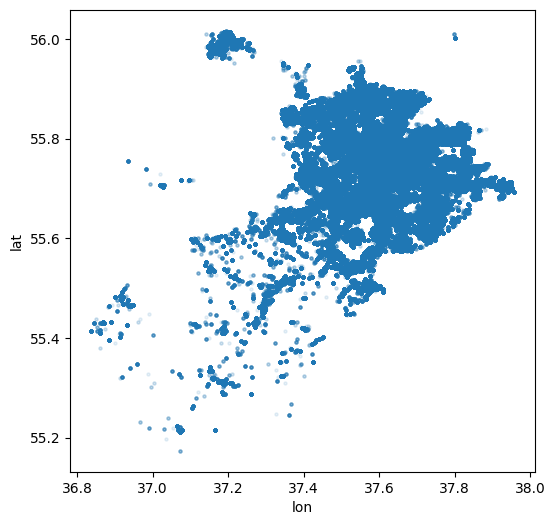

In [58]:
'''
Транзакции на карте
'''
transactions.plot(alpha=0.1, marker='.', figsize=(6, 6), x='lon', y='lat', kind='scatter')

In [59]:
hexses_target_dict = {}
for location in tqdm(hexses_target):
    hexses_target_dict[location] = h3.h3_to_geo(location)

100%|██████████| 1657/1657 [00:00<00:00, 390140.44it/s]


In [60]:
# Список локаций которых нет в транзакциях
loc_out = [x for x in hexses_target if x not in hexses_data]
loc_out

['8911aa4c2a3ffff', '8911aa63473ffff', '8911aa79c23ffff']

In [61]:
target = (
    target_df
    .assign(customer_id = lambda x: x.customer_id.astype(int))
    .pipe(lambda x: pd.pivot(x.assign(v = 1.), index='customer_id', columns='h3_09', values='v'))
    .pipe(lambda x: x.reindex(sorted(x.columns), axis=1)) # Сортируем столбцы по порядку
    .sort_values(by='customer_id') # сортируем строки
    .fillna(0)
)
target.shape

(69337, 1657)

In [62]:
target.head(3)

h3_09,8911818610bffff,89118195133ffff,8911819513bffff,891181b2827ffff,891181b2957ffff,891181b2b83ffff,891181b2b97ffff,891181b2ba7ffff,891181b2bb3ffff,891181b2d1bffff,...,8911aa7b5a7ffff,8911aa7b5b3ffff,8911aa7b617ffff,8911aa7b637ffff,8911aa7b643ffff,8911aa7b65bffff,8911aa7b663ffff,8911aa7b67bffff,8911aa7b687ffff,8911aa7b68fffff
customer_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
"""
Эвристика основана на том, что чем чаще клиент совершает транзакции в локации тем больше вероятность,
что он снимет наличность.

"""
class Personal():

    def __init__(self, probability: float):
        self.probability = probability


    def fit_predict(self, transactions: pd.DataFrame, hexses_target: List[np.array]):

        customer_list = []
        for customer_id, data in tqdm(transactions.groupby("customer_id")):
            location = data.h3_09.tolist()
            loc_text = []
            loc_feature = []
            for loc in hexses_target:
                if loc in location:
                    loc_count = location.count(loc)# Получаем вероятность отшошением кол-ва активностей на общую активность клиента
                    loc_feature.append((loc_count/len(location)))
                    loc_text.append(loc)
                else:
                    loc_feature.append(self.probability)#если нет активности константной вероятностью
                    loc_text.append(loc)

            customer_list.append([customer_id]+loc_feature)
        return pd.DataFrame(customer_list, columns = ['customer_id']+loc_text)

In [64]:
model = Personal(probability = 0.00110555)
customer_df = model.fit_predict(transactions, hexses_target)

100%|██████████| 69337/69337 [03:55<00:00, 294.38it/s]


In [65]:
print(f'MBCE: {mean_binary_cross_entropy(customer_df[target.columns].values,target)}')

MBCE: 13.859825728557903


In [66]:
def count_transform(df: pd.DataFrame,  hexses_data: List[np.ndarray]) -> pd.DataFrame:
    """
    Создание матрицы признаков на активности в каждой локации если активности нет заполняется -1

    """

    data_features = []
    for customer_id, data in tqdm(df.groupby("customer_id")):

        location = data.h3_09.tolist()
        loc_feature =[]
        loc_text = []

        for loc in hexses_data:

            if loc in location:
                loc_count = data[data.h3_09==loc]['count'].sum()# суммируем все активности в локации
                loc_feature.append(loc_count)
                loc_text.append(loc)
            else:
                loc_feature.append(-1)
                loc_text.append(loc)

        data_features.append([customer_id]+loc_feature)
    return pd.DataFrame(data_features, columns = ['customer_id']+loc_text)

In [67]:
train_data = count_transform(transactions, hexses_data)
print(train_data.shape, train_data.head(3))

100%|██████████| 69337/69337 [32:30<00:00, 35.54it/s]  


(69337, 8155)    customer_id  89118180927ffff  89118180d27ffff  891181820abffff  \
0            1               -1               -1               -1   
1            4               -1               -1               -1   
2            5               -1               -1               -1   

   891181840a7ffff  891181844c3ffff  89118184c93ffff  891181854b7ffff  \
0               -1               -1               -1               -1   
1               -1               -1               -1               -1   
2               -1               -1               -1               -1   

   89118186067ffff  8911818610bffff  ...  8911aa7b6b3ffff  8911aa7b6bbffff  \
0               -1               -1  ...               -1               -1   
1               -1               -1  ...               -1               -1   
2               -1               -1  ...               -1               -1   

   8911aa7b6c3ffff  8911aa7b6c7ffff  8911aa7b6cbffff  8911aa7b6cfffff  \
0               -1            

In [68]:
train_data = train_data.drop('customer_id',axis=1)

# **Создаём и обучаем модель**
*Используем XGBoost в качестве основной модели и StratifiedKFold для разделения данных на фолды*

In [ ]:
%time
from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold, MultilabelStratifiedKFold
from sklearn.metrics import log_loss

train_scores=[]
val_scores = []

MBCE_train_scores=[]
MBCE_val_scores = []

rmskf = MultilabelStratifiedKFold(n_splits=7, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(rmskf.split(train_data, target)):
    print(f'Fold: {fold}')
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = train_data.iloc[train_index], train_data.iloc[test_index]
    y_train, y_val = target.iloc[train_index], target.iloc[test_index]

    model = XGBClassifier(n_estimators=400,depth=4,nthread = -1,sampling_method='gradient_based',
                      objective="binary:logistic",tree_method='gpu_hist')


    model.fit(X_train, y_train,eval_set=[(X_val, y_val)],
          verbose=5,early_stopping_rounds=5)
    joblib.dump(model, f'model_{fold}.pkl')


    train_preds = model.predict_proba(X_train)
    valid_preds = model.predict_proba(X_val)

    train_score = log_loss(y_train, train_preds)
    val_score = log_loss(y_val, valid_preds)

    print(f'Результат log_loss на трейн: {train_score}')
    print(f'Результат log_loss на тесте: {val_score}')
    print('----------->')
    print(f'Результат MBCE на трейн: {mean_binary_cross_entropy(train_preds,y_train)}')
    print(f'Результат MBCE на тесте: {mean_binary_cross_entropy(valid_preds,y_val)}')


    train_scores.append(train_score)
    val_scores.append(val_score)

    MBCE_train_scores.append(mean_binary_cross_entropy(train_preds,y_train))
    MBCE_val_scores.append(mean_binary_cross_entropy(valid_preds,y_val))

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.63 µs
Fold: 0
TRAIN: [    0     1     2 ... 69333 69334 69336] TEST: [    4     8    13 ... 69321 69331 69335]
[0]	validation_0-logloss:0.09535
[5]	validation_0-logloss:0.02386
[10]	validation_0-logloss:0.00921
[15]	validation_0-logloss:0.00623
[20]	validation_0-logloss:0.00571
[25]	validation_0-logloss:0.00567
[28]	validation_0-logloss:0.00569
Результат log_loss на трейн: 5.744679342329822
Результат log_loss на тесте: 9.140721244491193
----------->
Результат MBCE на трейн: 5.0017437917517045
Результат MBCE на тесте: 9.388355902041063
Fold: 1
TRAIN: [    0     1     2 ... 69333 69335 69336] TEST: [    9    24    27 ... 69326 69327 69334]
[0]	validation_0-logloss:0.09537
[5]	validation_0-logloss:0.02389
[10]	validation_0-logloss:0.00925
[15]	validation_0-logloss:0.00628
[20]	validation_0-logloss:0.00577
[25]	validation_0-logloss:0.00574
[27]	validation_0-logloss:0.00576
Результат log_loss на трейн: 5.727192745574639
Результат log

In [ ]:
print(f'MBCE на валидации: {sum(MBCE_val_scores)/len(MBCE_val_scores)}')